In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_moons, make_blobs

plt.rcParams["figure.figsize"] = (7, 4)
RANDOM_STATE = 42

DATA_PATH = Path("archive/shopmania.csv")  # ajuste se precisar
assert DATA_PATH.exists(), f"Arquivo não encontrado: {DATA_PATH.resolve()}"

In [79]:
# Parte 1 - Explique com as suas palavras o que é e quais são os objetivos de uma tarefa de clusterização. Quais são suas vantagens e quais são suas maiores dificuldades?

**O que é:** agrupar dados parecidos sem rótulo (aprendizado não supervisionado)
**Objetivos:** achar padrões, segmentar perfis, resumir dados e preparar insumos para outras tarefas
**Vantagens:** ser simples (ex.: k-means), útil para exploração, reduz ruído
**Dificuldades:** escolher k, sensível a escala e outliers, supõe clusters “esféricos”, pode variar com a inicialização

In [80]:
# Parte 2 - Aplique o k-means na base de dados de comparação de produtos da ShopMania. Analise seus resultados. A seguir, o link para o dataset: https://www.kaggle.com/datasets/lakritidis/product-classification-and-categorization

In [81]:
raw = pd.read_csv(DATA_PATH)
num = raw.select_dtypes(include="number").copy()

low_var = [c for c in num.columns if num[c].nunique() <= 1]
num = num.drop(columns=low_var)

num = num.fillna(num.median(numeric_only=True))
scaler = StandardScaler()
X = scaler.fit_transform(num)

print("Matriz numérica:", X.shape)

pca_fast = PCA(n_components=min(20, X.shape[1]), random_state=RANDOM_STATE)
X_fast = pca_fast.fit_transform(X)
X_fast.shape

Matriz numérica: (313705, 2)


(313705, 2)

k= 2 | inertia=2,098 | silhouette(sample)=0.684
k= 3 | inertia=849 | silhouette(sample)=0.684
k= 4 | inertia=526 | silhouette(sample)=0.620
k= 5 | inertia=294 | silhouette(sample)=0.619
k= 6 | inertia=232 | silhouette(sample)=0.596
k= 7 | inertia=205 | silhouette(sample)=0.605
k= 8 | inertia=130 | silhouette(sample)=0.576
k= 9 | inertia=111 | silhouette(sample)=0.578
k=10 | inertia=78 | silhouette(sample)=0.594
k=11 | inertia=64 | silhouette(sample)=0.593
k=12 | inertia=58 | silhouette(sample)=0.571
k=13 | inertia=54 | silhouette(sample)=0.569
k=14 | inertia=50 | silhouette(sample)=0.550


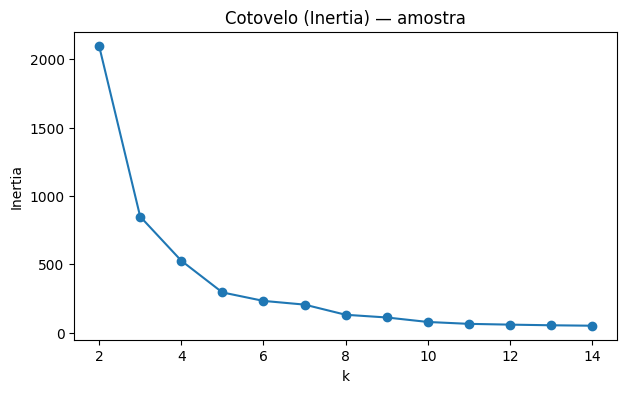

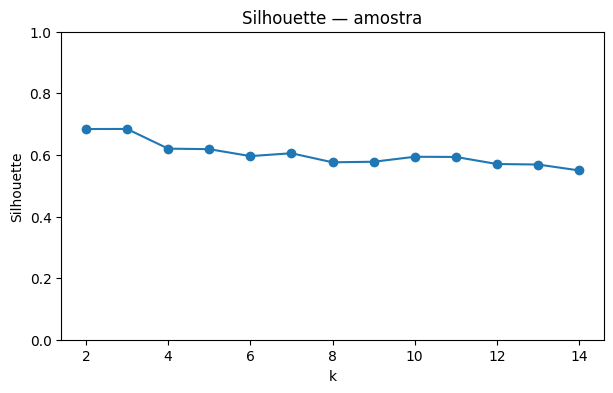

3

In [82]:
Ks = list(range(2, 15))

sample_size = min(5000, X_fast.shape[0])
rng = np.random.default_rng(RANDOM_STATE)
idx = rng.choice(X_fast.shape[0], size=sample_size, replace=False)
X_sample = X_fast[idx]

inertias, silhouettes = [], []

for k in Ks:
    model = MiniBatchKMeans(
        n_clusters=k,
        batch_size=1024,
        n_init=3,
        random_state=RANDOM_STATE
    )
    labels_sample = model.fit_predict(X_sample)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_sample, labels_sample))
    print(f"k={k:2d} | inertia={model.inertia_:,.0f} | silhouette(sample)={silhouettes[-1]:.3f}")

plt.figure()
plt.plot(Ks, inertias, marker="o")
plt.title("Cotovelo (Inertia) — amostra")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(Ks, silhouettes, marker="o")
plt.title("Silhouette — amostra")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.ylim(0, 1)
plt.show()

best_k = Ks[int(np.argmax(silhouettes))]
best_k

k=3 | silhouette(sample)=0.684 | inertia=52,475


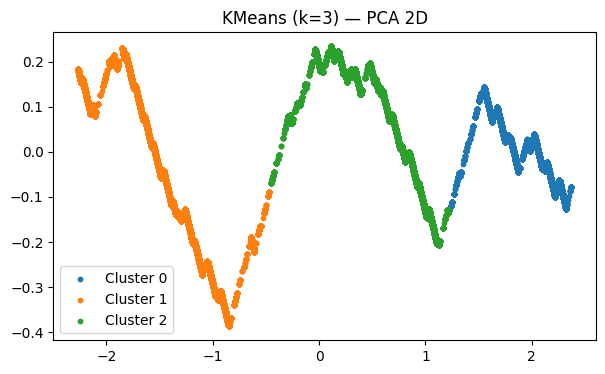

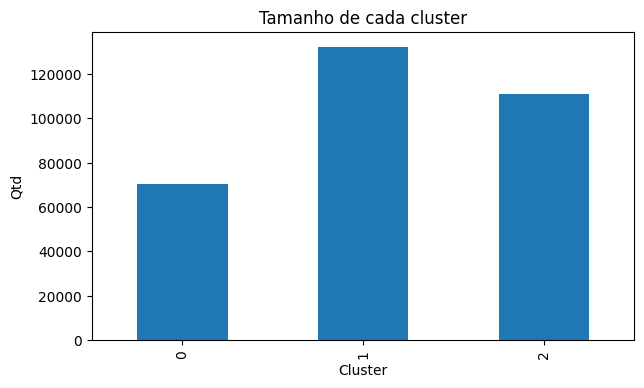

In [83]:
kfinal = best_k
kmeans = MiniBatchKMeans(
    n_clusters=kfinal,
    batch_size=1024,
    n_init=5,
    random_state=RANDOM_STATE
).fit(X_fast)

labels_full = kmeans.predict(X_fast)
sil = silhouette_score(X_sample, kmeans.predict(X_sample))
print(f"k={kfinal} | silhouette(sample)={sil:.3f} | inertia={kmeans.inertia_:,.0f}")

X2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_fast)

for c in range(kfinal):
    plt.scatter(X2[labels_full==c,0], X2[labels_full==c,1], s=10, label=f"Cluster {c}")
plt.title(f"KMeans (k={kfinal}) — PCA 2D")
plt.legend()
plt.show()

pd.Series(labels_full).value_counts().sort_index().plot(kind="bar")
plt.title("Tamanho de cada cluster")
plt.xlabel("Cluster"); plt.ylabel("Qtd")
plt.show()

In [84]:
# Parte 3 - De acordo com o que estudamos em sala de aula, descreva e explique quais as situações em que o algoritmo k-means falha, ou seja, quais situações em que a tarefa executada pelo algoritmo não chega a agrupamentos satisfatórios, capazes de representar adequadamente os dados no dataset.

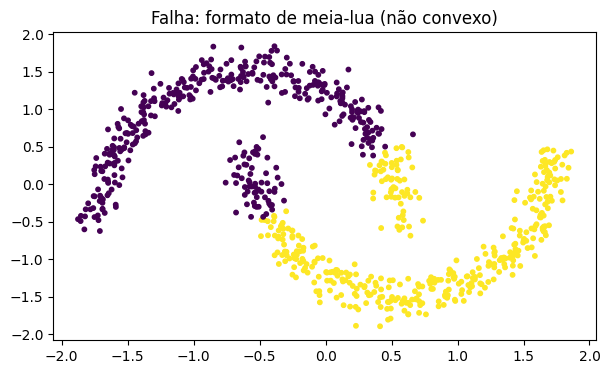

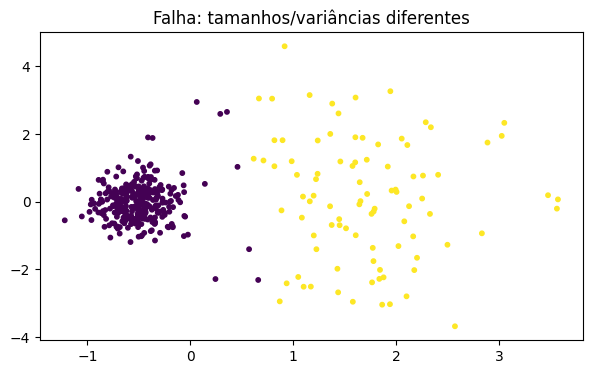

In [85]:
# moons
Xm, _ = make_moons(n_samples=800, noise=0.07, random_state=RANDOM_STATE)
Xm = StandardScaler().fit_transform(Xm)
lab_m = KMeans(n_clusters=2, n_init=5, random_state=RANDOM_STATE).fit_predict(Xm)
plt.scatter(Xm[:,0], Xm[:,1], c=lab_m, s=10)
plt.title("Falha: formato de meia-lua (não convexo)")
plt.show()

# blobs
Xb, _ = make_blobs(n_samples=[300,100], centers=[[-2,0],[2,0]],
                   cluster_std=[0.4,1.4], random_state=RANDOM_STATE)
Xb = StandardScaler().fit_transform(Xb)
lab_b = KMeans(n_clusters=2, n_init=5, random_state=RANDOM_STATE).fit_predict(Xb)
plt.scatter(Xb[:,0], Xb[:,1], c=lab_b, s=10)
plt.title("Falha: tamanhos/variâncias diferentes")
plt.show()

Logo, observa-se que o k-means falha nas seguintes situações:
- Clusters não esféricos (meia-lua/espiral) → fronteiras erradas.
- Densidades/tamanhos muito diferentes → centróides “puxam” pro cluster denso.
- Outliers e falta de padronização distorcem distâncias.
- Alta dimensionalidade atrapalha a noção de “perto/longe”.

In [86]:
# Parte 4 - Explique com as suas palavras como o algoritmo k-means pode ser usado para a quantização vetorial. Ilustre sua explicação aplicando uma quantização sobre o dataset make_blobs, que usamos em sala de aula.

Erro de quantização (MSE): 0.0218


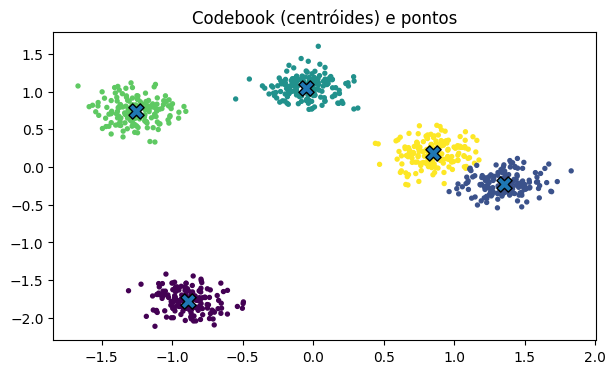

In [87]:
Xq, _ = make_blobs(n_samples=800, centers=5, cluster_std=0.8, random_state=RANDOM_STATE)
Xq = StandardScaler().fit_transform(Xq)

km_q = KMeans(n_clusters=5, n_init=10, random_state=RANDOM_STATE).fit(Xq)
centroids = km_q.cluster_centers_
labels_q = km_q.labels_

Xq_hat = centroids[labels_q]
mse = np.mean((Xq - Xq_hat)**2)
print("Erro de quantização (MSE):", round(mse, 4))

plt.scatter(Xq[:,0], Xq[:,1], c=labels_q, s=8)
plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k")
plt.title("Codebook (centróides) e pontos")
plt.show()

K-means aprende um **codebook** (centróides). Cada vetor vira o índice do centróide mais próximo → isso **comprime**/simplifica a representação. O MSE mede o erro da quantização.

In [88]:
# Parte 5 - O dataset da ShopMania (questão 2) inclui 230 categorias. Use o PCA para reduzir a dimensionalidade, refaça o processo de agrupamento e compare os resultados com aquele obtido na questão 2.

Dim orig: 2 → Dim PCA: 1
k= 2 | inertia=122,737 | silhouette(sample)=0.6942428567906199
k= 3 | inertia=45,970 | silhouette(sample)=0.7015893983263498
k= 4 | inertia=28,760 | silhouette(sample)=0.6209507459660584
k= 5 | inertia=16,410 | silhouette(sample)=0.6247188205922842
k= 6 | inertia=12,964 | silhouette(sample)=0.6153957414183336
k= 7 | inertia=10,143 | silhouette(sample)=0.5972074475212311
k= 8 | inertia=7,199 | silhouette(sample)=0.6079893705060343
k= 9 | inertia=5,257 | silhouette(sample)=0.6207450982468626
k=10 | inertia=4,091 | silhouette(sample)=0.6082543100953526
k=11 | inertia=3,759 | silhouette(sample)=0.5745719302682354
k=12 | inertia=3,014 | silhouette(sample)=0.5810436999815831
k=13 | inertia=2,717 | silhouette(sample)=0.5547347063876117
k=14 | inertia=2,245 | silhouette(sample)=0.5744646089410194
Best k (com PCA 95%): 3


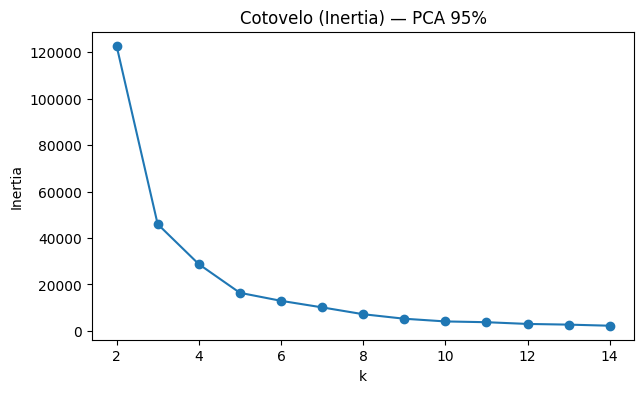

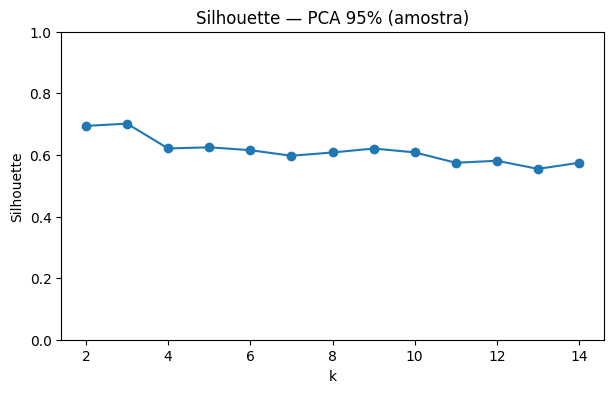

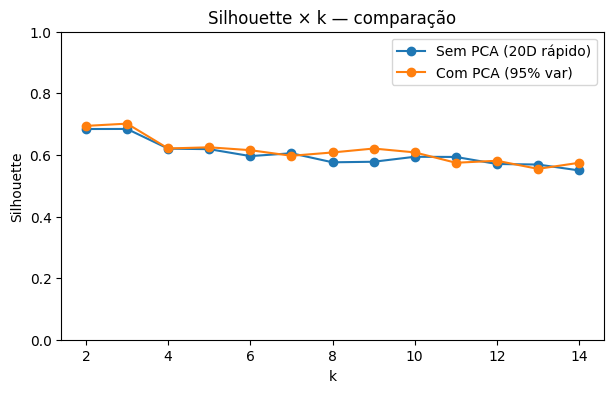

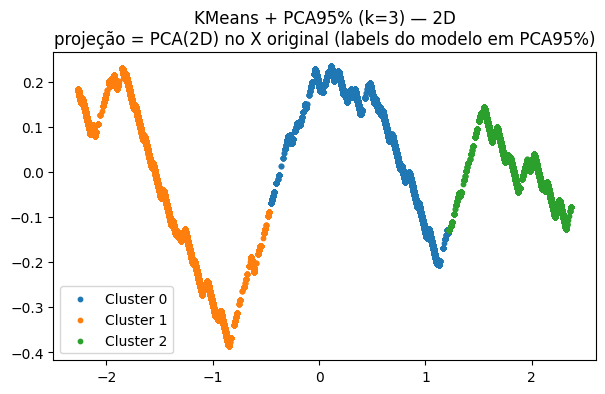

In [89]:
pca_full = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca_full.fit_transform(X)     # usa X já padronizado
print("Dim orig:", X.shape[1], "→ Dim PCA:", X_pca.shape[1])

Ks2 = list(range(2, 15))
sil_pca, inert_pca = [], []

sample_size2 = min(5000, X_pca.shape[0])
rng2 = np.random.default_rng(RANDOM_STATE)
idx2 = rng2.choice(X_pca.shape[0], size=sample_size2, replace=False)
X_pca_s = X_pca[idx2]

for k in Ks2:
    mb = MiniBatchKMeans(n_clusters=k, batch_size=1024, n_init=3,
                         random_state=RANDOM_STATE)
    mb.fit(X_pca)
    inert_pca.append(mb.inertia_)
    labels_s = mb.predict(X_pca_s)
    if np.unique(labels_s).size < 2:
        sil_pca.append(np.nan)
    else:
        sil_pca.append(silhouette_score(X_pca_s, labels_s))
    print(f"k={k:2d} | inertia={inert_pca[-1]:,.0f} | silhouette(sample)={sil_pca[-1]}")

# melhor k válido
valid = ~np.isnan(sil_pca)
if not valid.any():
    raise RuntimeError("Nenhum k válido para silhouette em PCA. Reduza a faixa de Ks ou aumente a amostra.")
best_k_pca = Ks2[int(np.nanargmax(sil_pca))]
print("Best k (com PCA 95%):", best_k_pca)

plt.figure()
plt.plot(Ks2, inert_pca, marker="o")
plt.title("Cotovelo (Inertia) — PCA 95%")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(Ks2, sil_pca, marker="o")
plt.title("Silhouette — PCA 95% (amostra)")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.ylim(0, 1)
plt.show()

try:
    _ = Ks, silhouettes
    plt.figure()
    plt.plot(Ks, silhouettes, marker="o", label="Sem PCA (20D rápido)")
    plt.plot(Ks2, sil_pca, marker="o", label="Com PCA (95% var)")
    plt.title("Silhouette × k — comparação")
    plt.xlabel("k"); plt.ylabel("Silhouette"); plt.ylim(0, 1)
    plt.legend(); plt.show()
except NameError:
    pass

mb_final = MiniBatchKMeans(n_clusters=best_k_pca, batch_size=1024, n_init=5,
                           random_state=RANDOM_STATE).fit(X_pca)
labels_pca = mb_final.labels_

if X_pca.shape[1] >= 2:
    X2p = X_pca[:, :2]
    subtitle = "projeção = duas primeiras PCs do PCA95%"
else:
    X2p = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)
    subtitle = "projeção = PCA(2D) no X original (labels do modelo em PCA95%)"

for c in range(best_k_pca):
    plt.scatter(X2p[labels_pca == c, 0], X2p[labels_pca == c, 1], s=10, label=f"Cluster {c}")
plt.title(f"KMeans + PCA95% (k={best_k_pca}) — 2D\n{subtitle}")
plt.legend(); plt.show()

- **Sem PCA (20D rápido)**: k={best_k} | silhouette≈{max(silhouettes):.3f} (amostra)  
- **Com PCA (95% var.)**: k={best_k_pca} | silhouette≈{max(sil_pca):.3f} (amostra)  

O PCA costuma reduzir ruído/colinearidade → às vezes melhora a separação dos grupos. Todavia, nem sempre ganha; logo, comparar torna-se obrigatório.